# Example: Kepler long-cadence light curve of KIC 4458832

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams; rcParams["figure.dpi"] = 250
import numpy as np
from SPLS.Generate_LC_template import Generator

### Data after simple preprocessing

try


/Users/shuyuezheng/Desktop/SPLS_folder/SPLS/Generate_LC_template.py:72: RuntimeWarning: invalid value encountered in arccos
  k1 = np.arccos((1-p**2+z**2)/2/z)
/Users/shuyuezheng/Desktop/SPLS_folder/SPLS/Generate_LC_template.py:73: RuntimeWarning: invalid value encountered in arccos
  k0 = np.arccos((p**2+z**2-1)/2/p/z)
/Users/shuyuezheng/Desktop/SPLS_folder/SPLS/Generate_LC_template.py:74: RuntimeWarning: invalid value encountered in sqrt
  return 1-np.where(1+p<z,0,np.where((np.abs(1-p)<z)&(z<=1+p),1/np.pi*(p**2*k0+k1-np.sqrt((4*z**2-(1+z**2-p**2)**2)/4)),np.where(z<=1-p,p**2,1)))


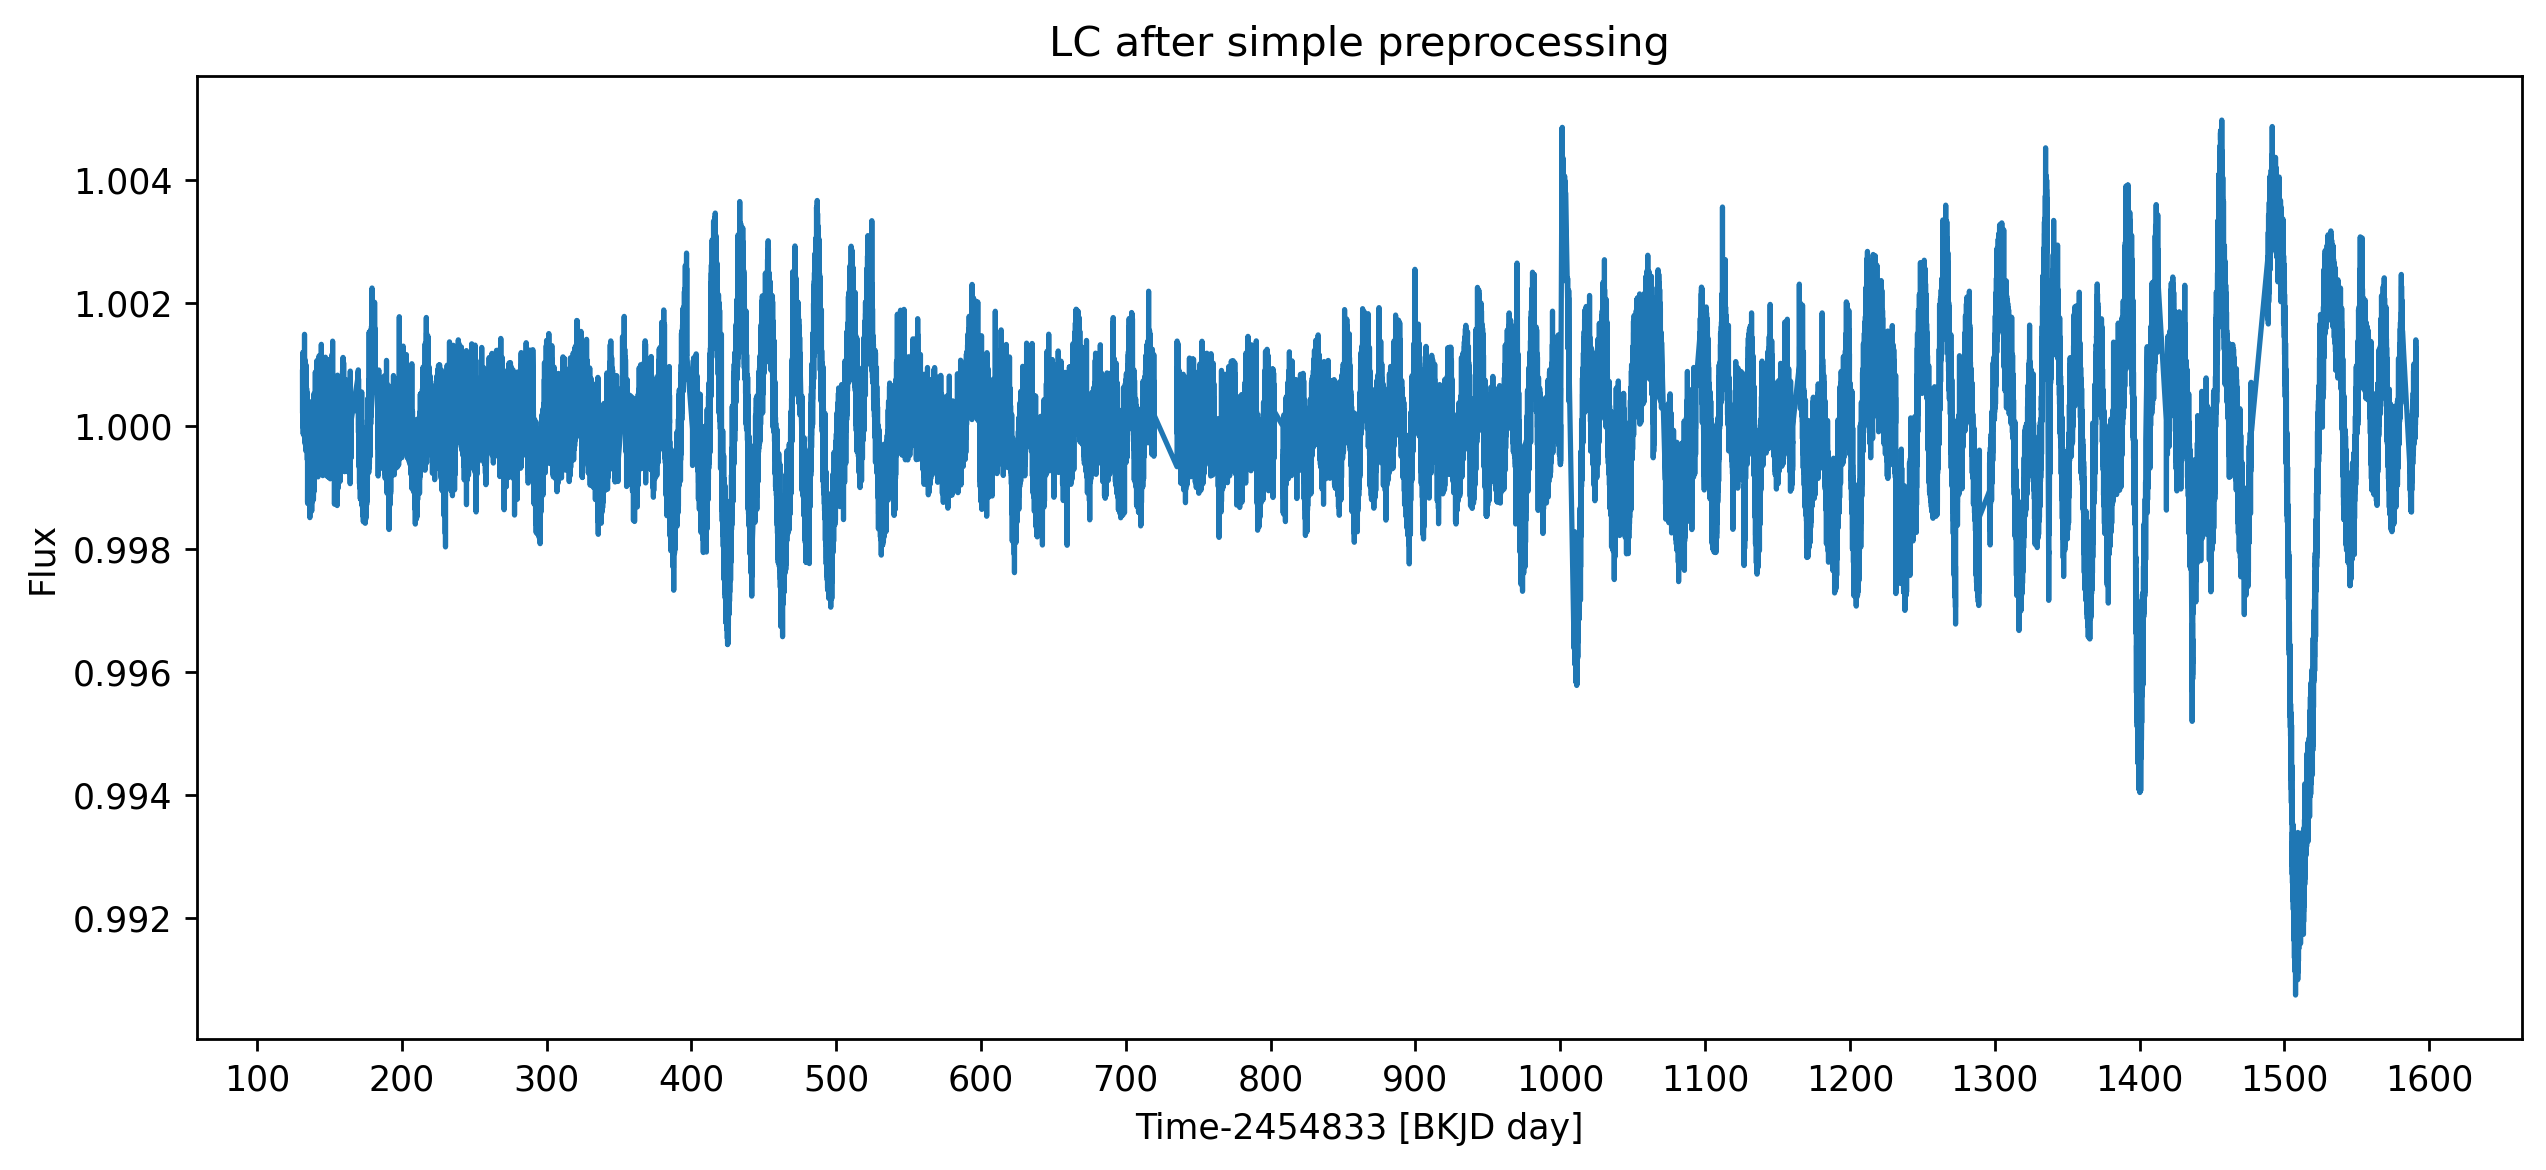

In [2]:
LC = pd.read_csv(f'./example_data/KIC4458832.csv')
t = np.array(LC['t'])
f = np.array(LC['f'])
df = np.array(LC['df'])

# Inject a transiting planet
p_p = 125 # orbital period in days
p_i = 4.22664112316555 # [0, 2*np.pi]
p_r = 2.2773438372714 # planet radius in Earth radii
M_target = 1	
R_target = 1
T_target = 5778
logg_target = 4.44
feh_target = 0
Gene = Generator() 
res = Gene.Run(t,star = {'teff':T_target,'mh':feh_target,'logg':logg_target,'radius':R_target,'mass':M_target},planet = {'radius':p_r,'period':p_p,'initial_phase':p_i})
f *= res
df *= res 
plt.figure(figsize=(12,5))
plt.plot(t,f)
plt.xlabel('Time-2454833 [BKJD day]')
plt.ylabel('Flux')
plt.title(f'LC after simple preprocessing')
plt.locator_params(axis='x', nbins=30)
plt.show()

### 0. Segmentation

The light curve is divided into 140 segments according to time gaps.


/Users/shuyuezheng/anaconda3/lib/python3.10/site-packages/numba/core/utils.py:612: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  warnings.warn("First-class function type feature is experimental",


Default best trend order is 1 for 27591 segments in the model comparison.


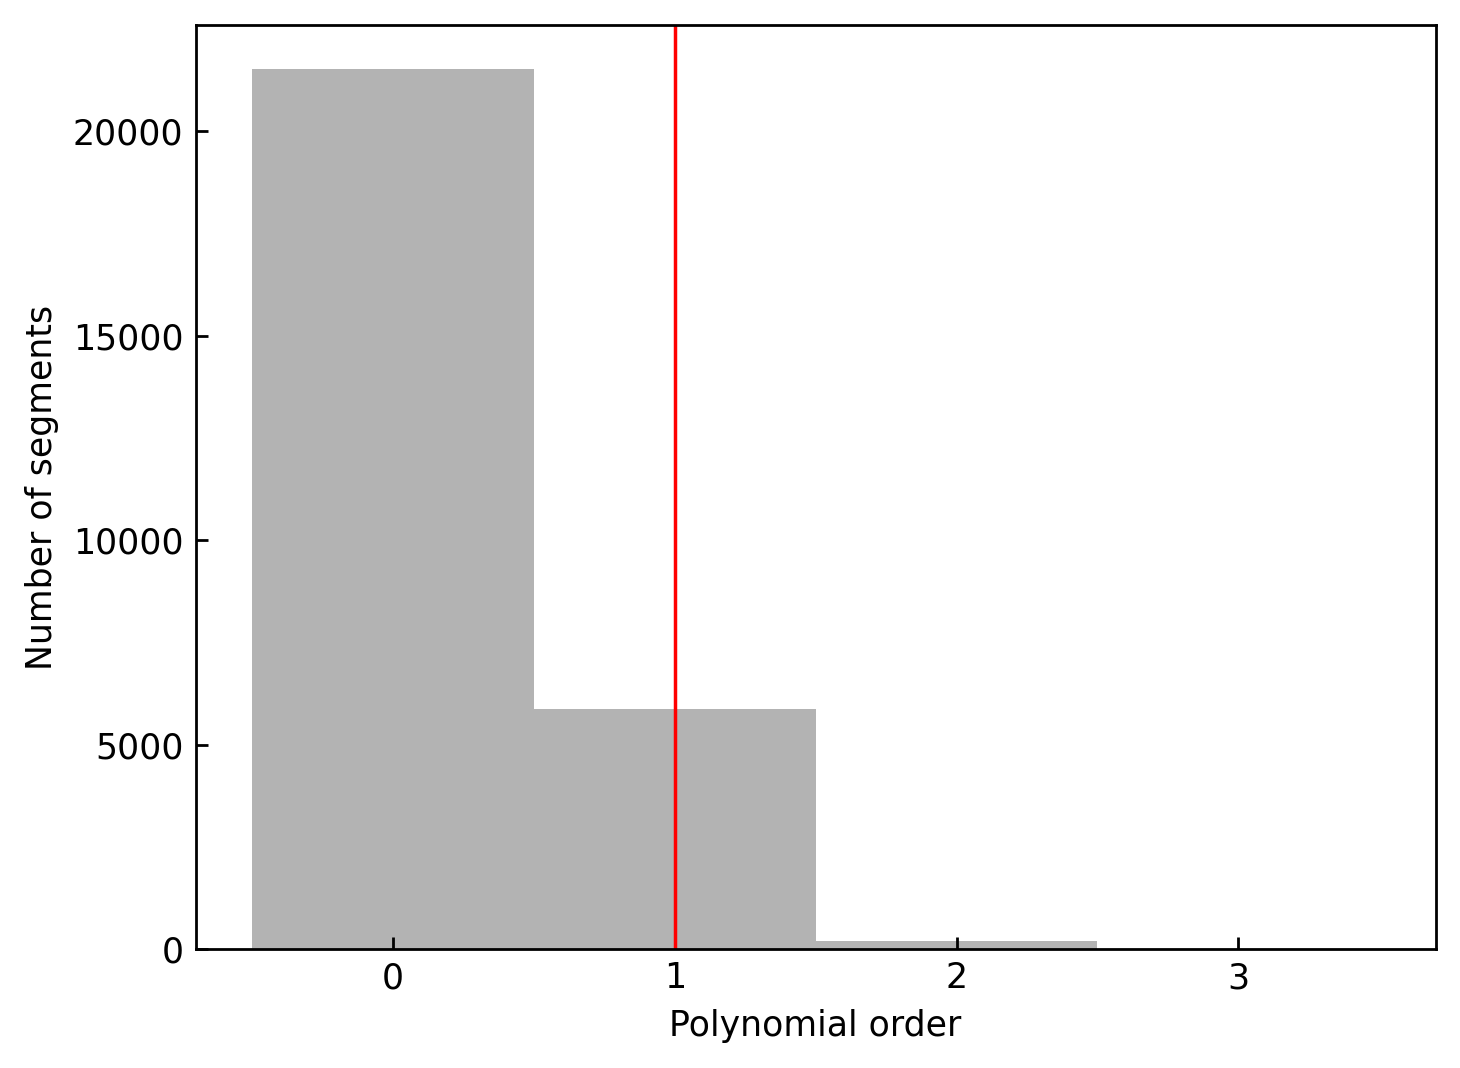

In [3]:
from SPLS import SPLeastSquares
SPsearch = SPLeastSquares(t,f,df)

# Segment the time series data based on time and flux gaps. 
SPsearch.step0_segment(flux_gap=False)
# Determine the default optimal polynomial order for the background trend component.
dmax = 0.5671165243726908
window = 2*dmax
trend_order = SPsearch.step0_default_trend_order(dmax, window)

### 1. Linear search

In [4]:
# Default sampled transit durations
sig_order = 4
d_sam = SPsearch.step1_pre_default_dsam1(sig_order,dmax,OS_d=8)
# Linear search to construct a 2D log-likelihood difference map
max_workers = 7
Pmin_step1 = 50
result_linear = SPsearch.step1_linear_search(trend_order, sig_order, 
                                            d_sam, window,
                                            max_workers,
                                            Pmin_step1,
                                            OS_tm=5
                                            )

Sample 8 transit durations from 0.081713811728 day to 0.5671165243726908 day.
Sample 305864 mid-transit times


/Users/shuyuezheng/anaconda3/lib/python3.10/site-packages/numba/core/utils.py:612: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  warnings.warn("First-class function type feature is experimental",
100%|██████████| 140/140 [00:18<00:00,  7.60it/s]


Linear search cost time 0.31905056635538737 min


In [5]:
vars(result_linear).keys()

dict_keys(['dlnL', 'tm_sam', 'd_sam'])

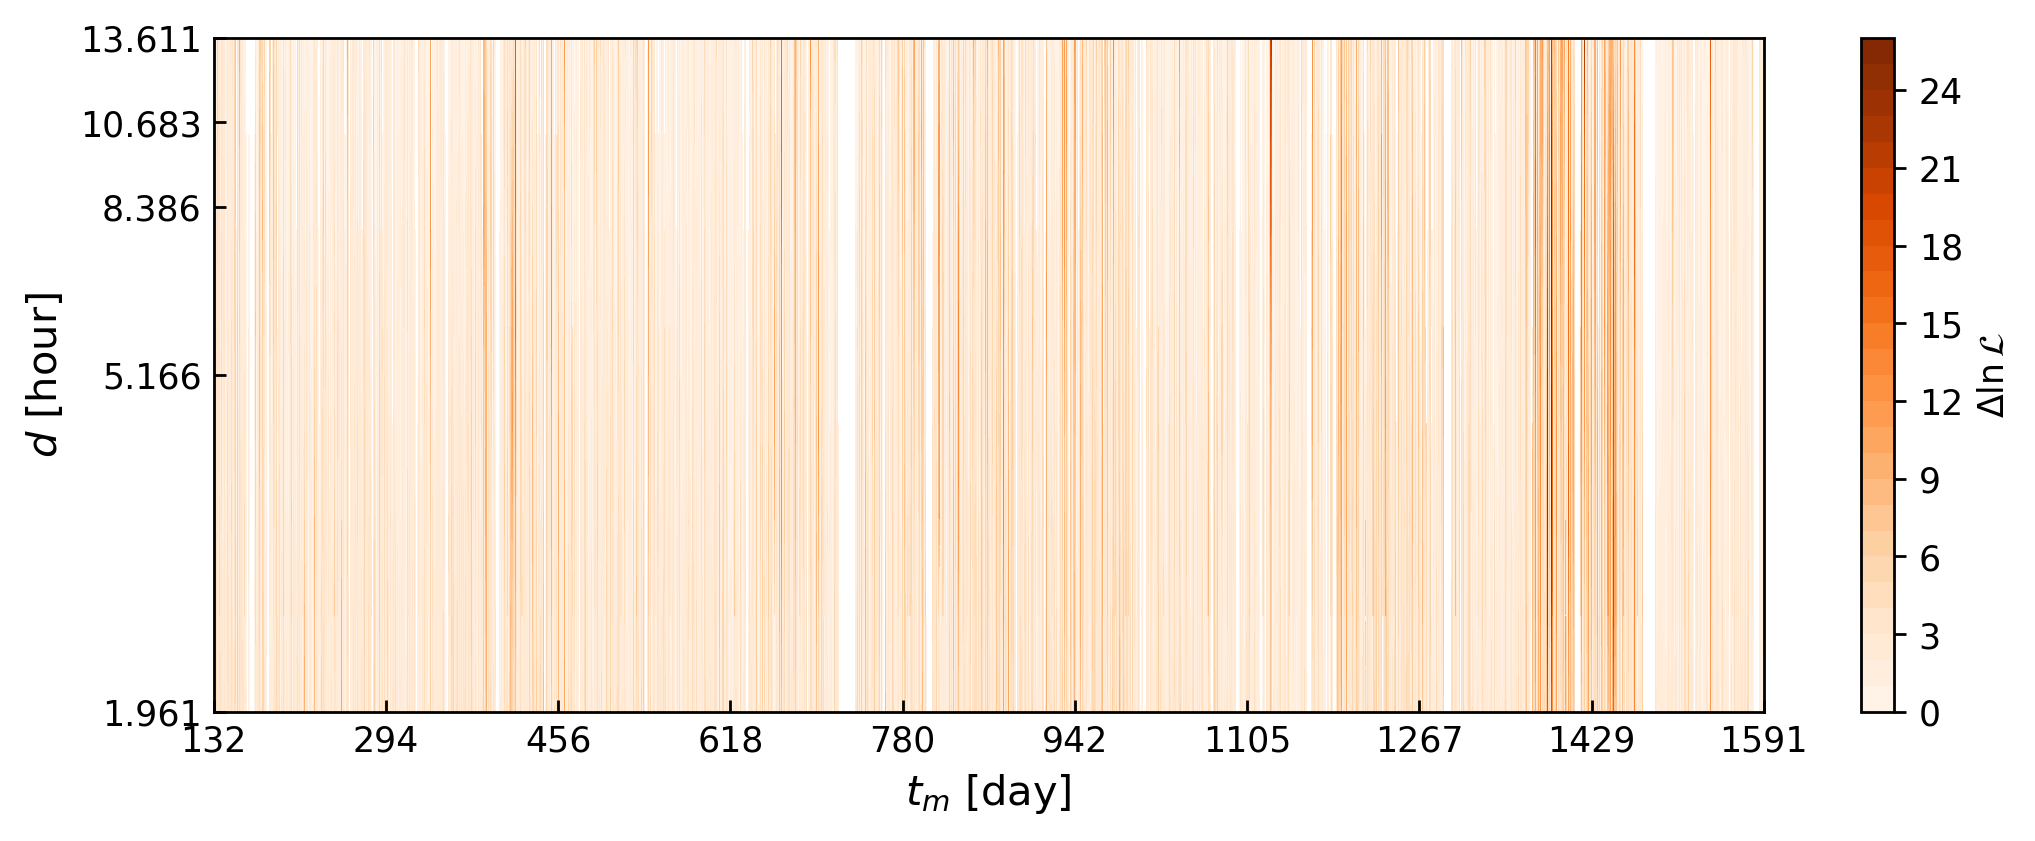

In [6]:
result_linear.plot()

### 2. Periodogram (including periodic search and global fitting)

In [7]:
# Default sampled periods
min_num_transit=3
P_sam = SPsearch.step2_pre_default_Psam(Pmin_step2=110,Pmax_step2=140,min_num_transit=min_num_transit)
# periodic search and global fitting to construct a periodogram
result_periodogram = SPsearch.step2_periodogram(P_sam, min_num_transit)

/Users/shuyuezheng/anaconda3/lib/python3.10/site-packages/numba/core/utils.py:612: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  warnings.warn("First-class function type feature is experimental",


Sample 1867 periods from 110.01032837037836 day to 139.99693284295662 day.


100%|██████████| 1867/1867 [05:21<00:00,  5.80it/s]


P_best 125.00435445917827 day
d_best 10.320170043731297 hours
tm0_best 165.88325400488876 day
SDE_best 15.302101825044353
Periodic search and global fitting cost time 5.366747784614563 min
0.0005756054907963826


In [8]:
vars(result_periodogram).keys()

dict_keys(['d_sam', 'P_sam', 'dlnL_arr', 'SDE_arr', 'P_best', 'd_best', 'tm0_best', 'SDE_best', 'number_segments_at_best_parameters', 'data_number_in_transits', 'data_number_in_segments', 'depth_best', 'depth_sigma_best', 'depth_snr', 't_cut_list', 'phase_cut_list', 'f_cut_list', 'model_t_cut_list', 'model_phase_cut_list', 'model_f_cut_list', 'phase_cut_sort', 'de_f_cut_sort', 'model_phase_cut_sort', 'model_de_f_cut_sort', 't', 'f'])

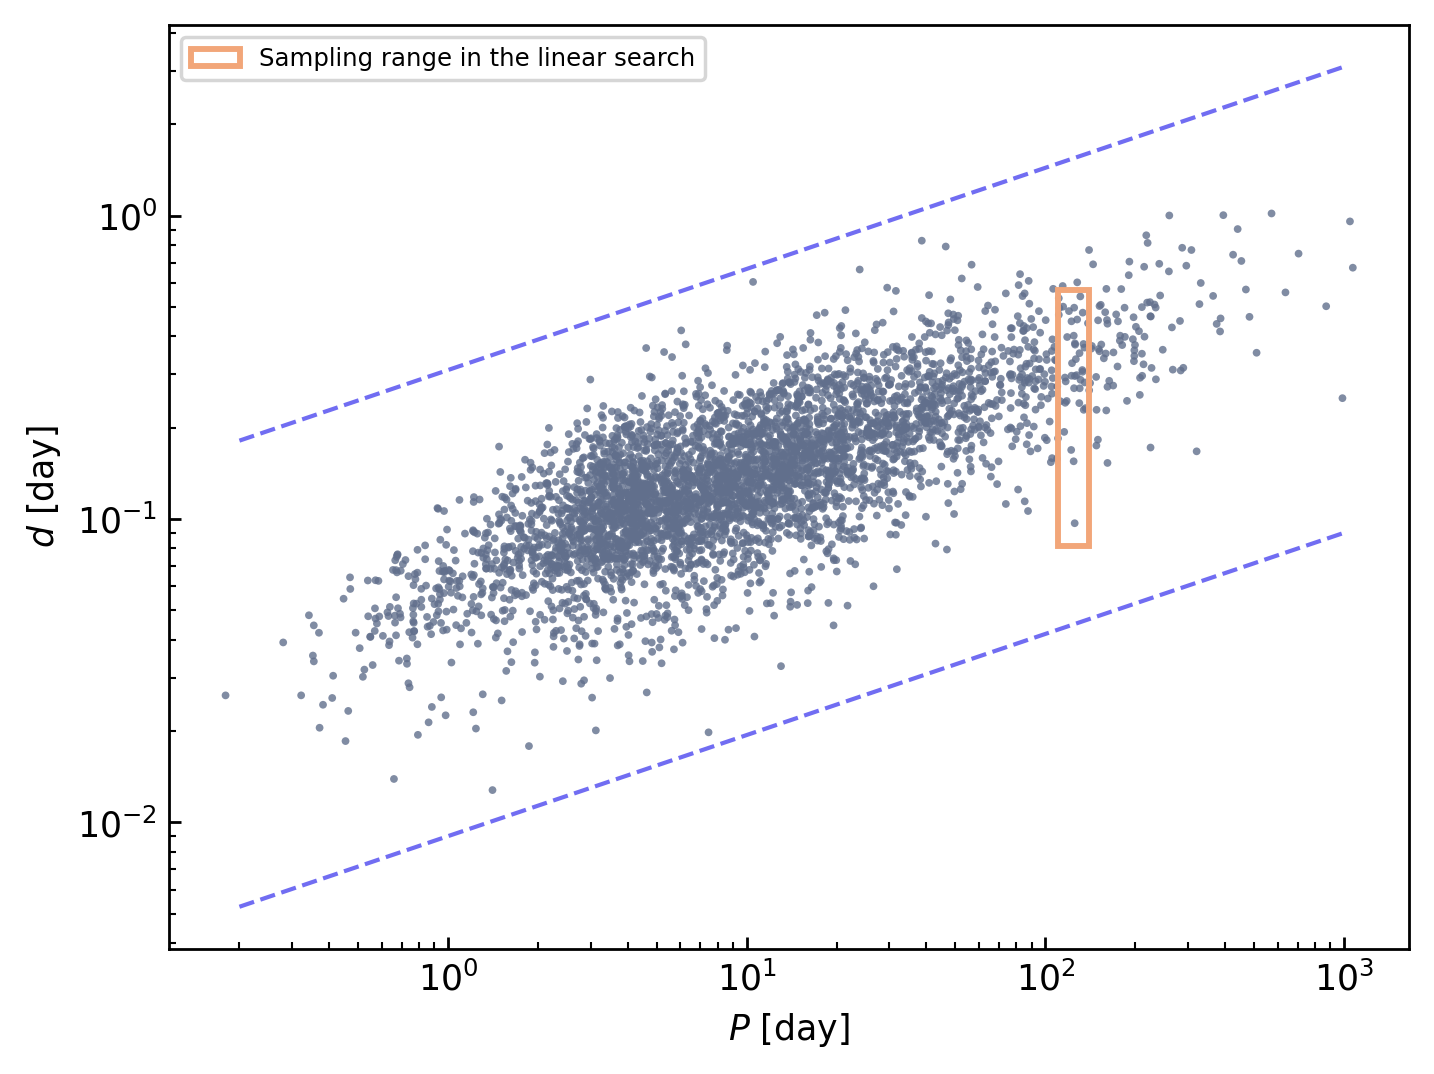

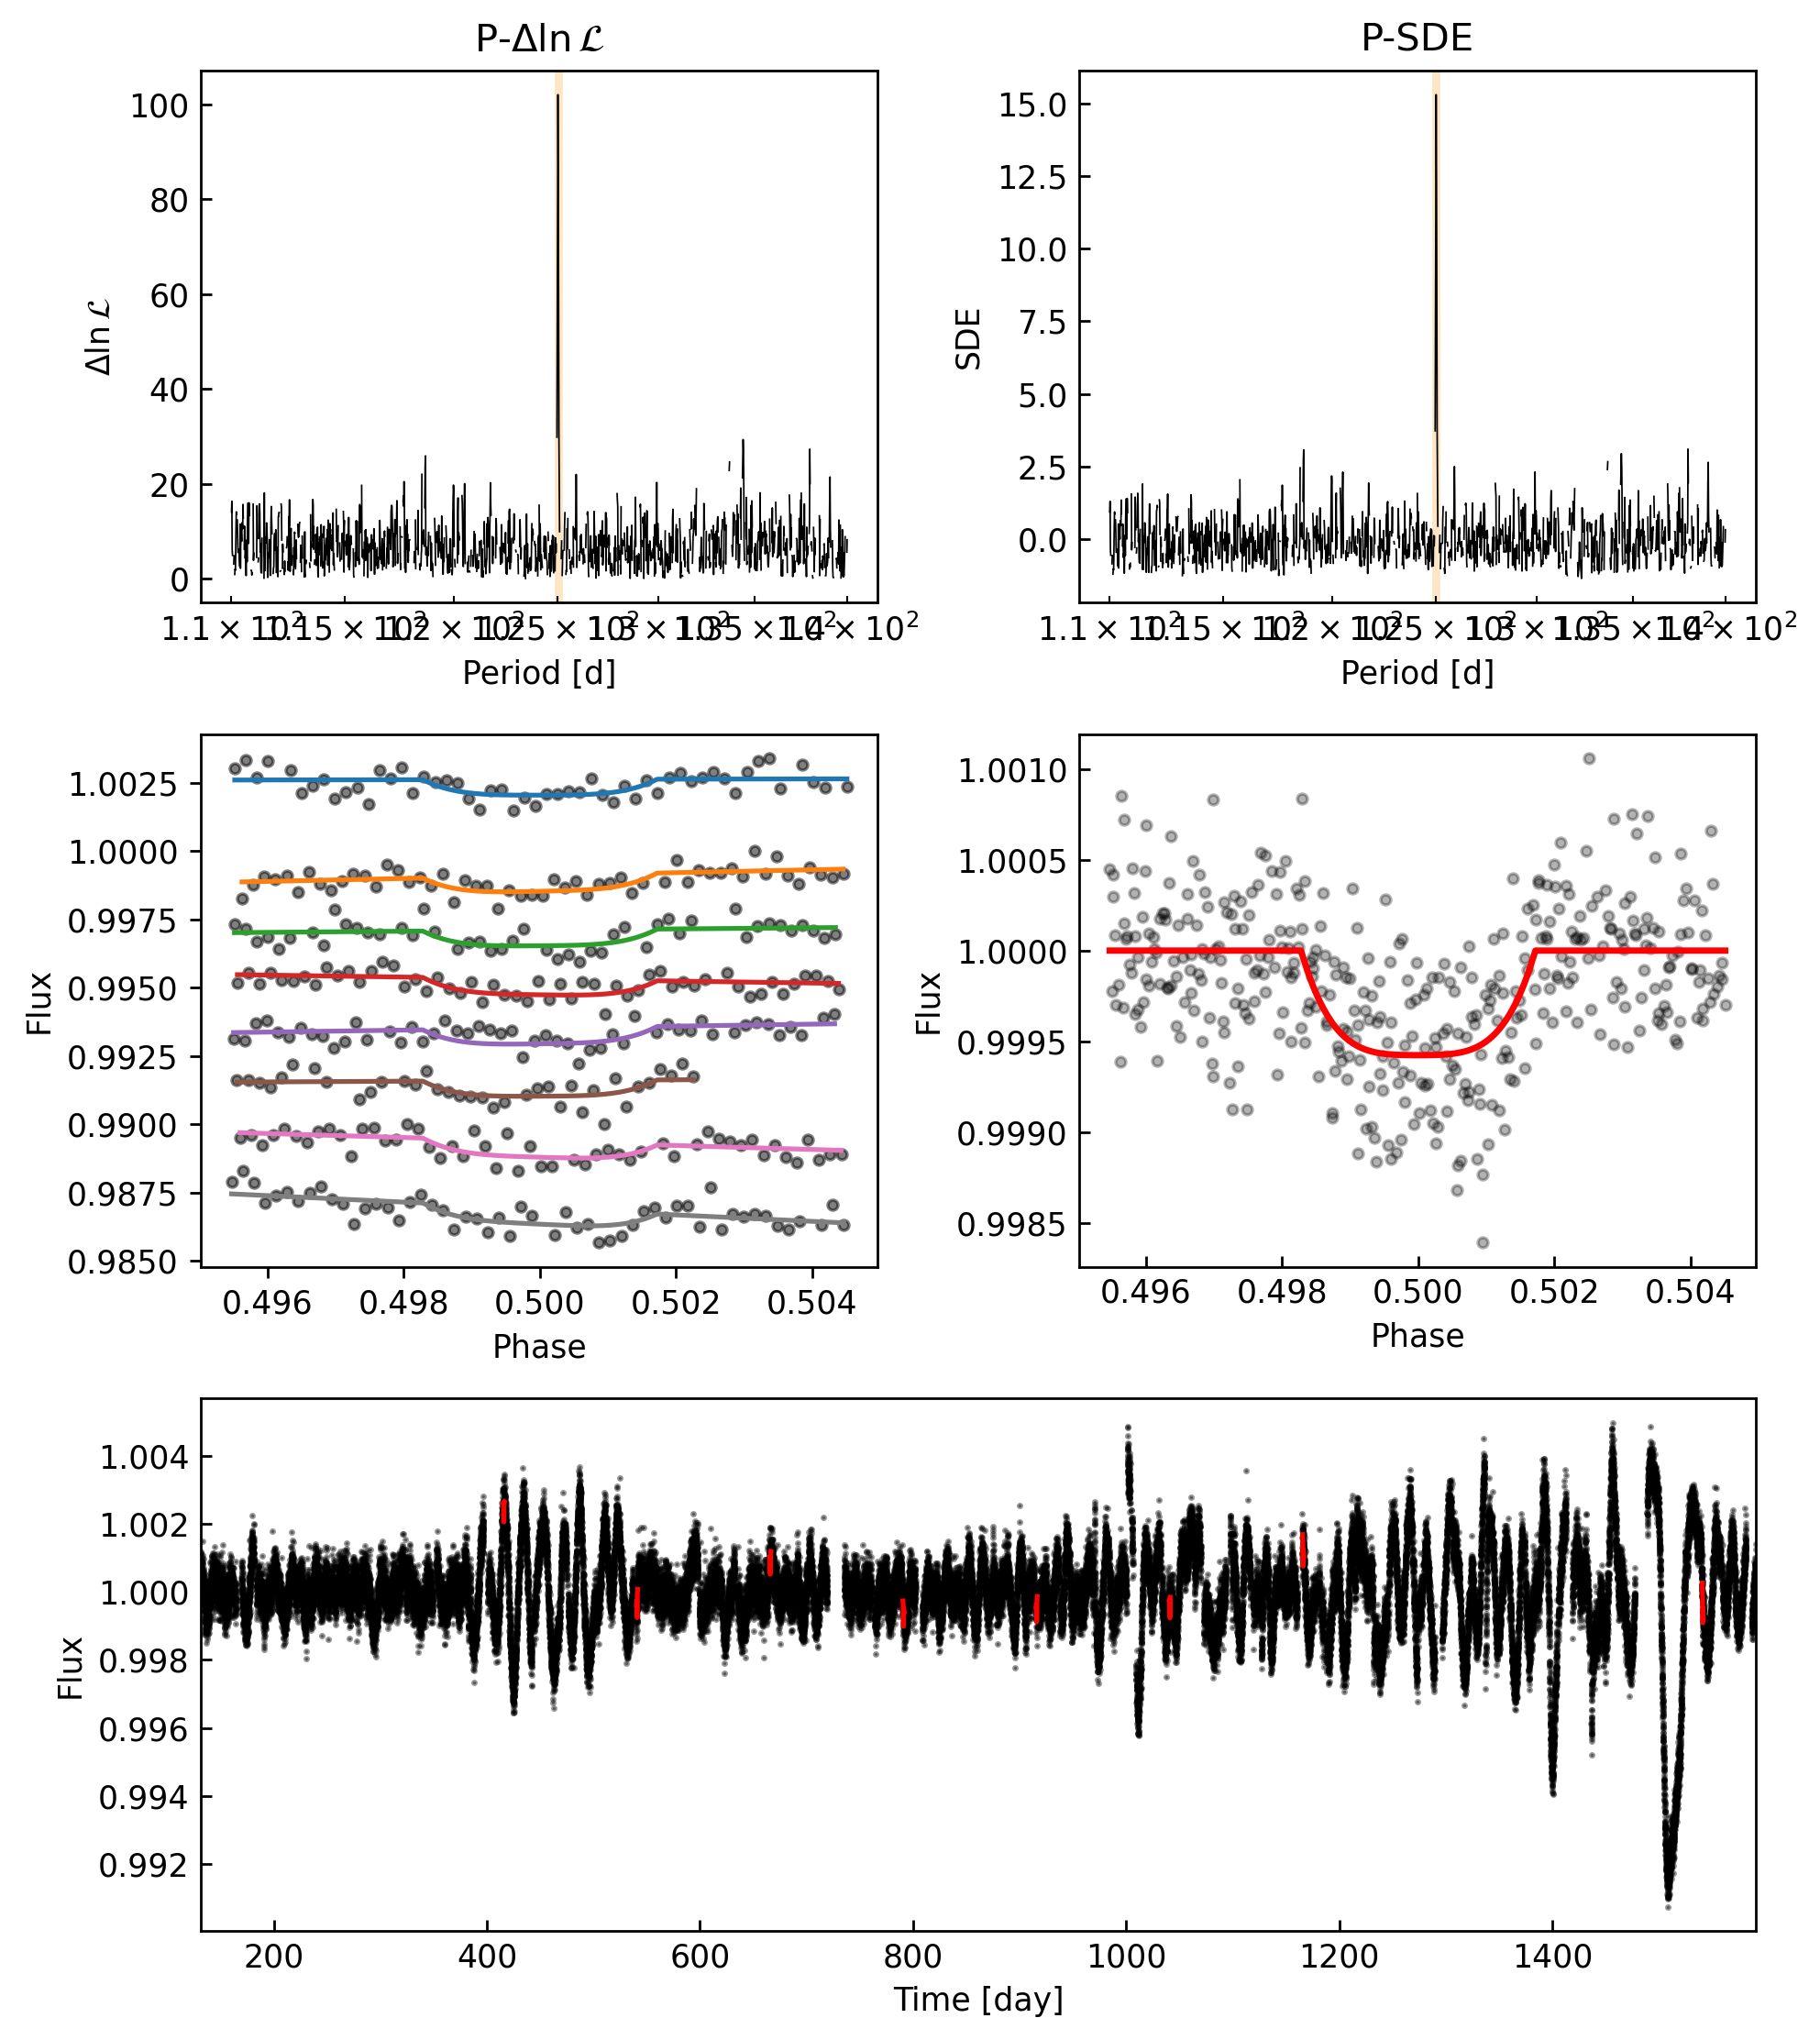

In [9]:
result_periodogram.plots()
